## Baby attempt at algorithm for determining transects

### some notes
`isel` with `xr` coordinate (index).\
Returns datavariable in `n` coordinate (ID).

## Part 1: Create mask
### Objective
We will use the mask to select all of the cells that appear in the original mask. We will

<ol>
    <li>Select all of the cells that appear in the original mask.</li>
    <li>Of those cells, select their corresponding vertices and edges to include inside the mask (this prevents cells from being halved if the original mask were to be applied).</li>
    <li>Select these cells, edges, and vertices in the base_mask to create a new mask.</li>
    <li>Apply this mask to the dso datavariable to plot the datavariable in the new masked area.</li>
</ol>

In [1]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools
from mpas_tools.planar_hex import make_planar_hex_mesh
from mpas_tools.mesh.conversion import convert, cull, mask
from mpas_tools.io import write_netcdf
from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from geometric_features import read_feature_collection
from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import json
import mosaic

### Set up datasets
**To create a base mask (a global "mask" filled with 1s):**
```ruby
# create a global base mask of ones everywhere. 
# We will then apply the mask where we specifically choose nCells, nVertices, and nEdges that are contained in the original mask to this basemask 
# This creates a new mask with all parts of the cell included. 


# create a base mask
mask['regionCellMasks'] = mask.regionCellMasks * 0 + 1
mask['regionVertexMasks'] = mask.regionVertexMasks * 0 + 1
mask['regionEdgeMasks'] = mask.regionEdgeMasks * 0 + 1
mask['regionNames'] = 'whole cell LS'
mask.attrs['How to use'] = 'open separate dataset with nCell, nVertices, nEdges xr index arrays. base_mask.regionCellMasks.where(base_mask.nCells.isin(cells_inside),other = 0)'
mask.to_netcdf('/global/homes/k/kuyeda/WMT_NBs/mpas-o_EC30to60_global_base_mask.nc',format='netCDF4',mode='w')
mask
```

**To convert the original mask .geojson file to a .nc file:**
```ruby
# convert geojson to .nc mask file

wmtnb_filepath = '/global/u2/k/kuyeda/WMT_NBs/'
fcMask = read_feature_collection(wmtnb_filepath + 'LS_test.geojson')
# pool = create_pool(process_count=8)
dsMasks = compute_mpas_region_masks(
    dsMesh, fcMask, maskTypes=('cell', 'vertex', 'edge'), pool=pool
)
# dsMasks.to_netcdf(wmtnb_filepath + 'LS_CEV_masks.nc', format='NETCDF4', mode='w')
```

### Open necessary datasets
```mesh``` $\rightarrow$ contains information about the mesh and cells \
```dso``` $\rightarrow$ diagnostics from the simulations (datavariables we actually want to plot) \
```mask``` $\rightarrow$ a mask of 0s and 1s created from a geojson file (created using geojson.io) that was then converted into a netcdf file using ```compute_mpas_region_masks``` \
```base_mask``` $\rightarrow$ a mask of 1s for the entire globe.


In [2]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open original (from geojson file) mask to use to make dataset smaller
wmtnb_filepath = './'
mask = xr.open_dataset(wmtnb_filepath + 'LS_CEV_masks.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')

/tmp/ipykernel_957249/3657922681.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


### functions to convert between index (xr) and ID (n) 

In [3]:
def n_to_xr_idx(n):
    return n-1

def xr_to_n_idx(xr):
    return xr+1

This code below can be rewritten to use `mesh.indexToEdgeID` or something related to it, but the I/O was messed up the day that I was doing this, so we're using the `n_to_xr_idx` and the `xr_to_n_idx` functions.
Also, just subtracting one feels easier and there is a straightforward conversion from ID (n) to index (xr) values. But the equivalent functions are below
```ruby
def xr_to_n_idx(xr):
    return xr+1
```

The equivalent conversion from  the index (xr) to ID (n) is
```ruby
cell_part = 'Cell' # 'Edge', 'Vertex'
ds = mesh
def idx_to_id(idx,cell_part,ds):
    id = ds[f'indexTo{cell_part}ID'].isel(nCells=idx).values
    return id
```

### function to get cells, edges, and vertices inside a mask

In [4]:
def xr_inside_mask_info(mesh,mask):
    # STEP 1: Select all of the cells inside teh mask
    # create mask of cells so that whole cells are included in the mask
    cellmask = mask.regionCellMasks.isel(nRegions=0).astype(bool)
    
    # --------- GET CELLS IN XR COORDINATES --------------
    # apply the mask to the mesh 
    # this returns cells in the xr coordinate
    xr_cells_inside = np.int32(mesh.nCells.where(cellmask,drop=True))
    
    # --------- GET VERTICES IN XR COORDINATES --------------
    
    # we also need all the vertices associated with the cells_inside masked mesh
    # this returns vertices in the n coordinate
    n_vertices_inside = mesh.verticesOnCell.isel(nCells=xr_cells_inside)
    
    # we want the vertices in the xr coordinate
    xr_vertices_inside_raw = n_to_xr_idx(n_vertices_inside)
    
    # remove repeat vertex values, remove -1 values (these were originally 0s and represented "blank" array spaces where there were fewer than 7 vertices
    xr_vertices_inside = np.delete(np.unique(xr_vertices_inside_raw), np.unique(xr_vertices_inside_raw)==-1)
    
    # --------- GET EDGES IN XR COORDINATES --------------
    
    # we also need all the edges associated with the cells_inside masked mesh
    # this returns edges in the n coordinate
    n_edges_inside = mesh.edgesOnCell.isel(nCells=xr_cells_inside)
    
    # we want  the edges in the xr coordinate
    xr_edges_inside_raw = n_to_xr_idx(n_edges_inside)
    
    # remove repeat edge values, remove -1 values (these were originally 0s and represented "blank" array spaces where there were fewer than 7 edges
    xr_edges_inside = np.delete(np.unique(xr_edges_inside_raw), np.unique(xr_edges_inside_raw)==-1)

    return xr_cells_inside, xr_vertices_inside, xr_edges_inside

### Step 1 & 2. Select all of the cells that appear inside the original mask and their corresponding vertices and edges. 

In [5]:
xr_cells_inside, xr_vertices_inside, xr_edges_inside = xr_inside_mask_info(mesh,mask)

### Step 3. Create a new mask that contains all of the cells inside with their corresponding vertices and edges. 

In [6]:
base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(xr_cells_inside), other = 0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(xr_vertices_inside), other = 0)
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(xr_edges_inside), other = 0)
LS_mask_whole_cells = base_mask

In [7]:
# convert the 1s and 0s new mask to boolean T/F
cellmask = LS_mask_whole_cells.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = LS_mask_whole_cells.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = LS_mask_whole_cells.regionVertexMasks.isel(nRegions=0).astype(bool)

### Step 4. Apply this mask to the dso variable to plot the datavariable in the new masked area. 

(51.5, 68.0)

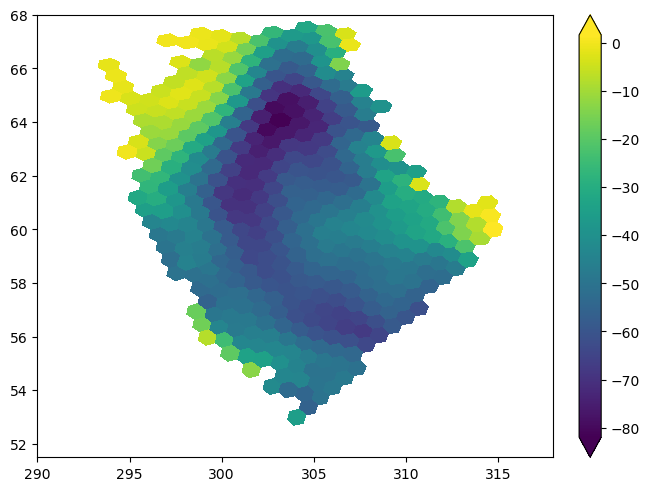

In [8]:

# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# ds_t0 = dso['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=30,Time=0)

ds_t0 = dso['timeMonthly_avg_latentHeatFlux'].isel(Time=0)

# remove the nans
if ds_t0.min() < -9**33:
    ds_nonans = ds_t0.where(ds_t0 > -9**33)
    print('fake nans detected')
else:
    ds_nonans = ds_t0

# apply the mask
ds_masked = ds_nonans.where(cellmask,drop=False)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  ds_masked,cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)

<div class="alert alert-block alert-info">
<b>All above this is correct:</b> Stop.
</div>

## Part 2: Algorithm to create transects

## Identify transect based on desired transect location

### function to select dso data inside mask

In [9]:
def format_ds(xr_cells_inside_ints, ds, datavariable):
    # select just the cells in the masked area
    ds_masked = ds[datavariable].isel(nCells=xr_cells_inside_ints)

    # remove the nans
    if ds_masked.min() > 10**33:
        print('fake nans detected')
        ds_nonans = ds_masked.where(ds != ds_masked.min())
    else:
        ds_nonans = ds_masked

    # select a specific time
    ds_formatted = ds_nonans.to_dataset(name=datavariable)
    
    return ds_formatted

### function to calculate distance between 2 points on a sphere (directly copied from henri's `sectionate/section.py` script

In [10]:
def distance_on_unit_sphere(lon1, lat1, lon2, lat2, R=6.371e6, method="vincenty"):
    """
    Calculate geodesic arc distance between points (lon1, lat1) and (lon2, lat2).

    PARAMETERS:
    -----------
        lon1 : float
            Start longitude(s), in degrees
        lat1 : float
            Start latitude(s), in degrees
        lon2 : float
            End longitude(s), in degrees
        lat2 : float
            End latitude(s), in degrees
        R : float
            Radius of sphere. Default: 6.371e6 (realistic Earth value). Set to 1 for
            arc distance in radius.
        method : str
            Name of method. Supported methods: ["vincenty", "haversine", "law of cosines"].
            Default: "vincenty", which is the most robust. Note, however, that it still can result in
            vanishingly small (but crucially non-zero) errors; such as that the distance between (0., 0.)
            and (360., 0.) is 1.e-16 meters when it should be identically zero.

    RETURNS:
    --------

    dist : float
        Geodesic distance between points (lon1, lat1) and (lon2, lat2).
    """
    
    phi1 = np.deg2rad(lat1)
    phi2 = np.deg2rad(lat2)
    dphi = np.abs(phi2-phi1)
    
    lam1 = np.deg2rad(lon1)
    lam2 = np.deg2rad(lon2)
    dlam = np.abs(lam2-lam1)
    
    if method=="vincenty":
        numerator = np.sqrt(
            (np.cos(phi2)*np.sin(dlam))**2 +
            (np.cos(phi1)*np.sin(phi2) - np.sin(phi1)*np.cos(phi2)*np.cos(dlam))**2
        )
        denominator = np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(dlam)
        arc = np.arctan2(numerator, denominator)
        
    elif method=="haversine":
        arc = 2*np.arcsin(np.sqrt(
            np.sin(dphi/2.)**2 + (1. - np.sin(dphi/2.)**2 - np.sin((phi1+phi2)/2.)**2)*np.sin(dlam/2.)**2
        ))
    
        
    elif method=="law of cosines":
        arc = np.arccos(
            np.sin(phi1)*np.sin(phi2) + np.cos(phi1)*np.cos(phi2)*np.cos(dlam)
        )

    return R * arc


### function that uses an algorithm to create transects given a start and end point. 

In [11]:
# function to calculate transect given a target start point, target end point, and mesh
def calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, mesh, mask):
    """
    Calculate transects given a defined target start and end point.

    PARAMETERS:
    -----------
        target_start_lat : float
            Target start latitude, in degrees
        target_start_lon : float
            Target start longitude, in degrees
        target_end_lat : float
            Target end latitude, in degrees
        mesh: xarray.core.dataset.Dataset
            Mesh dataset containing lat/lon Cell/Edge/Vertex
        mask: xarray.core.dataset.Dataset
            Mask of 0s and 1s to define the desired study region (can be created using __ function)
            
    RETURNS:
    -----------
        next_vertices: np.ndarray
            xr indices of nVertices that define the transect
        xr_transect_edges: np.ndarray
            xr indices of edges that define the transect
        
    """
    # ---------- INITIATE START VERTEX ----------------
    # of these transect cells, select the one that is closest to the desired starting point.
    # desired values in deg
    # distance_on_unit_sphere(lon1, lat1, lon2, lat 2)
    # find the shortest path between the two points
    # of all of the points, find the vertex that is closest to the desired start point
    distance = distance_on_unit_sphere(mesh.lonVertex * 180/np.pi, mesh.latVertex * 180/np.pi, target_start_lon, target_start_lat)
    xr_start_vertex = distance.argmin()
    n_start_vertex = xr_to_n_idx(xr_start_vertex)

    # repeat to find the vertex that is closest to the desired end point
    dist_to_end = distance_on_unit_sphere(mesh.lonVertex * 180/np.pi, mesh.latVertex * 180/np.pi, target_end_lon, target_end_lat)
    xr_end_vertex = dist_to_end.argmin()
    end_lon = mesh.isel(nVertices = xr_end_vertex).lonVertex * 180/np.pi
    end_lat = mesh.isel(nVertices = xr_end_vertex).latVertex * 180/np.pi

    print('start vertex is ','(lon,lat)= (', np.float32(mesh.lonVertex.isel(nVertices=xr_start_vertex).values * 180/np.pi), 
                                             ', ' , np.float32(mesh.latVertex.isel(nVertices=xr_start_vertex).values * 180/np.pi), ')')
    print('start vertex xr_index is ', xr_start_vertex.values)

    # ---------- FIND NEXT VERTEX ----------------
    start_vertices = np.array([])
    next_vertices = np.array([])
    
    count = 0

    while distance.min() > 5000:
        # get the edges attached to the start vertex
        n_edgesOnStartVertex = mesh.edgesOnVertex.isel(nVertices = xr_start_vertex)
        xr_edgesOnStartVertex = n_to_xr_idx(n_edgesOnStartVertex)
        
        # check that the edges you selected are connected to the start vertex (returns in n indices)
        # mesh.verticesOnEdge.isel(nEdges = xr_edgesOnStartVertex[0])
        
        # for each of these edges, find the vertices they are connected to and then remove the start_vertex (we don't want to "travel back" to that vertex)
        n_vertices_nextToStartVertex = np.unique(mesh.verticesOnEdge.isel(nEdges = np.int32(xr_edgesOnStartVertex)))
        xr_vertices_nextToStartVertex = n_to_xr_idx(n_vertices_nextToStartVertex)
        # print(xr_vertices_nextToStartVertex)
    
        used_vertices = np.union1d(start_vertices, xr_start_vertex)
        
        xr_vertices_nextToStartVertex_Use = np.delete(xr_vertices_nextToStartVertex, np.where(np.isin(xr_vertices_nextToStartVertex, used_vertices)))
        # print(xr_vertices_nextToStartVertex_Use)
        # calculate the distance from these new vertices to the desired end point
            # retrieve the lat and lon of the vertex
        ds_vertices_nextLatLon = mesh[['lonVertex','latVertex']].where(mesh.nVertices.isin(xr_vertices_nextToStartVertex_Use))
        ds_vertices_nextLatLon['lonVertex'] = ds_vertices_nextLatLon.lonVertex * 180 / np.pi
        ds_vertices_nextLatLon['latVertex'] = ds_vertices_nextLatLon.latVertex * 180 / np.pi
        
            # calculate the distance between the next vertices and the end
        distance = distance_on_unit_sphere(ds_vertices_nextLatLon.lonVertex, ds_vertices_nextLatLon.latVertex, end_lon, end_lat)
        
            # select the nVertex that is the shortest distance from the end point
        xr_chosen_nextVertex = distance.argmin()
        
        # ---------- UPDATE ARRAYS ----------------
        # store vertices
        start_vertices = np.append(start_vertices, xr_start_vertex)
        next_vertices = np.append(next_vertices, xr_chosen_nextVertex)
    
        xr_start_vertex = xr_chosen_nextVertex 
    
        # if count%100==0:
        #     print('(lon,lat)= (', mesh.lonVertex.isel(nVertices=xr_chosen_nextVertex).values * 180/np.pi, mesh.latVertex.isel(nVertices=xr_chosen_nextVertex).values * 180/np.pi, ')')
        #     print('xr vertex = ', xr_start_vertex.values)
        count +=1
        if distance.min() < 10000: # 1 grid cell ~ 100km. distance is measured in meters (see R units) 
            break

# ---------- FIND EDGES OF TRANSECT ---------------- 
    # We want to identify the edges that connect the vertices. The vertices are already ordered consecutively (because the transects are built from an algorithm)
    # We will take advantage of this fact using a for loop to extract the edges that are shared between vertices next to each other
    
    # modify next_vertices to also include the start vertex
    next_vertices = np.insert(next_vertices, 0, n_to_xr_idx(n_start_vertex))

    
    # next vertices are in xr indices
    int_next_vertices = np.int32(next_vertices)
    n_transect_edges = np.array([])
    
    for i in range(0,len(int_next_vertices)-1):
        edgesOnVertex0 = mesh.edgesOnVertex.isel(nVertices = int_next_vertices[i]).values
        edgesOnVertex1 = mesh.edgesOnVertex.isel(nVertices = int_next_vertices[i+1]).values
        shared_edge = np.intersect1d(edgesOnVertex0, edgesOnVertex1)
        n_transect_edges = np.append(n_transect_edges, shared_edge)
    
    xr_transect_edges = n_to_xr_idx(n_transect_edges)

    # we also want to identify the cells that border the edges and vertices...
    # this is harder because we need to define to which side of the cells we would like to define the mask.

    return next_vertices, xr_transect_edges
        

### function to calculate transects given multiple points

In [12]:
# calculate transects using multiple points

# make_transect_nv, make_transect_e = calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, mesh, mask)
def calculate_transects_multiple_pts(segment_lons,segment_lats,mesh,mask):
    all_xr_transect_vertices = np.array([])
    all_xr_transect_edges = np.array([])
    for i in range(0,len(segment_lons)-1):
        
        # set start and end target points based on segment lons and lats
        target_start_lat = segment_lats[i]
        target_start_lon = segment_lons[i]

        target_end_lat = segment_lats[i+1]
        target_end_lon = segment_lons[i+1]
        
        xr_next_vertices, xr_transect_edges_segment = calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, mesh, mask)

        # update all_xr_transect_ arrays
        all_xr_transect_vertices = np.concatenate((all_xr_transect_vertices, xr_next_vertices))
        all_xr_transect_edges = np.concatenate((all_xr_transect_edges, xr_transect_edges_segment))

    return all_xr_transect_vertices, all_xr_transect_edges
        

### calculate transects from algorithm 

In [13]:
# # # LS
target_start_lat, target_start_lon = 54, 302
target_end_lat, target_end_lon = 60, 315
next_vertices, xr_transect_edges = calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, mesh, mask)

start vertex is  (lon,lat)= ( 302.24057 ,  54.05217 )
start vertex xr_index is  264002


(51.5, 68.0)

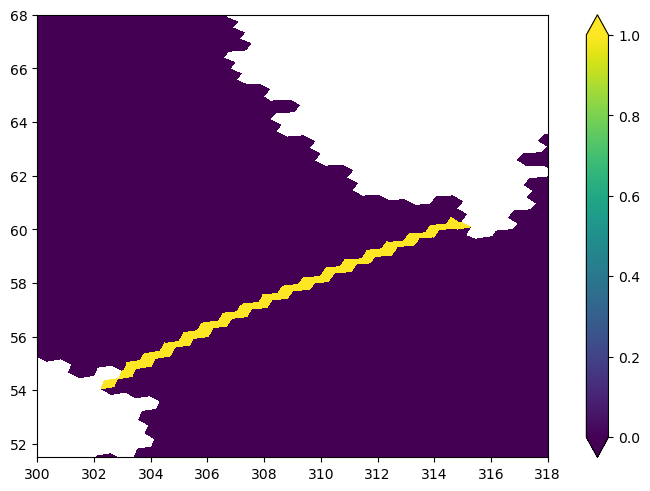

In [14]:
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# LS
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(xr_transect_edges),other=0)

# GofM
# base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=1)

edgemask = base_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)

# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  edgemask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')

# LS
ax.set_xlim(300, 318)
ax.set_ylim(51.5, 68)

# # GofM
# ax.set_xlim(250, 318)
# ax.set_ylim(15, 35)

In [15]:
LS_lats= np.array([54, 60, 66, 64, 58])   
LS_lons= np.array([302, 315, 310, 295, 296])

LS_lats = np.append(LS_lats, LS_lats[0])
LS_lons = np.append(LS_lons, LS_lons[0])

test_verts, test_edges = calculate_transects_multiple_pts(LS_lons, LS_lats, mesh, mask)

start vertex is  (lon,lat)= ( 302.24057 ,  54.05217 )
start vertex xr_index is  264002
start vertex is  (lon,lat)= ( 315.2718 ,  60.094044 )
start vertex xr_index is  157224
start vertex is  (lon,lat)= ( 307.87173 ,  65.39093 )
start vertex xr_index is  310634
start vertex is  (lon,lat)= ( 295.1961 ,  63.954773 )
start vertex xr_index is  408499
start vertex is  (lon,lat)= ( 297.02753 ,  58.27477 )
start vertex xr_index is  59513


(51.5, 68.0)

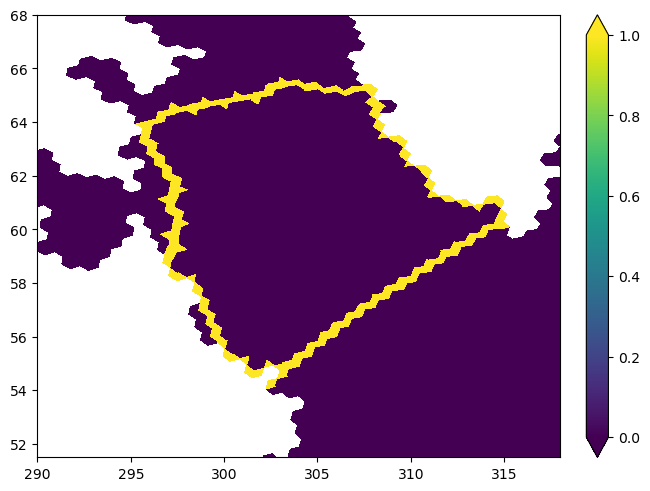

In [16]:
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# LS
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(test_edges),other=0)

# GofM
# base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=1)

edgemask = base_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)

# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  edgemask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')

# LS
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)

# # GofM
# ax.set_xlim(250, 318)
# ax.set_ylim(15, 35)

<div class="alert alert-warning" role="alert">
  <b>END OF TRANSECT CREATION FROM ALGORITHM </b> 
</div>


## identify transect based on mask

## An attempt to select edge cells that surround the mask without using an algorithm

### these are cells on the edge but NOT inside. 

In [67]:
xr_cells_inside, xr_vertices_inside, xr_edges_inside = xr_inside_mask_info(mesh,mask)

In [68]:
# get all cells on edge
masked_mesh = mesh.isel(nCells=xr_cells_inside,nEdges=xr_edges_inside,nVertices=xr_vertices_inside)

nCellsOnEdge = np.unique(masked_mesh.cellsOnEdge)

xrCellsOnEdge = n_to_xr_idx(nCellsOnEdge)

xr_border_cells = xrCellsOnEdge[~np.isin(xrCellsOnEdge, xr_cells_inside)]

n_border_cells = n_to_xr_idx(xr_border_cells)


# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# #base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(n_border_cells+1), other = 1)
# base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(xr_border_cells), other = 1)



In [69]:
# --------------- GET BORDER VERTICES IN XR COORDINATES ---------------
# get the vertices that correspond to the xr_border_cells
# this returns vertices in n coordinate
n_border_vertices = mesh.verticesOnCell.isel(nCells = xr_border_cells)

# we want the vertices in the xr coordinate
xr_border_vertices_raw = n_to_xr_idx(n_border_vertices)

# remove repeat vertex values, remove -1 values (these were origianlly 0s and represented "blank array spaces")
xr_border_vertices = np.delete(np.unique(xr_border_vertices_raw),np.unique(xr_border_vertices_raw)==-1)

# --------------- GET BORDER EDGES IN XR COORDINATES ---------------
# get the edges that correspond to the xr_border_cells
n_border_edges = mesh.edgesOnCell.isel(nCells = xr_border_cells)

# we want the edges in the xr coordinate
xr_border_edges_raw = n_to_xr_idx(n_border_edges)

# remove repeat edge values, remove -1 values (these were origianlly 0s and represented "blank array spaces")
xr_border_edges = np.delete(np.unique(xr_border_edges_raw),np.unique(xr_border_edges_raw)==-1)

In [70]:
# --------------- GET VERTICES IN MASK AND ON BORDER CELLS ---------------
# get the cells that share an edge with the border cells
n_cellsOnBorderEdges = np.unique(mesh.cellsOnEdge.isel(nEdges = xr_border_edges))
xr_cellsOnBorderEdges = n_to_xr_idx(n_cellsOnBorderEdges)

# we only want the cells that share an edge with the border cells AND are inside the mask
mask_transect_cells = np.intersect1d(xr_cellsOnBorderEdges, xr_cells_inside)

# we want vertices that are in the border cell vertices AND in the mask vertices
xr_transect_vertices = np.intersect1d(xr_border_vertices, xr_vertices_inside)
n_transect_vertices = xr_to_n_idx(xr_transect_vertices)


# now we connect these vertices... Uhhh do I actually even have to do this
# choose a starting point
transect_vertices_ds = mesh[['latVertex', 'lonVertex']].isel(nVertices = xr_transect_vertices)

# get the edges that connect these vertices
n_transect_edgesOnVertex = mesh.edgesOnVertex.where(mesh.nVertices.isin(xr_transect_vertices),drop='all')
xr_transect_edgesOnVertex = n_to_xr_idx(n_transect_edgesOnVertex)

# --------------- GET EDGES IN MASK AND ON BORDER CELLS ---------------
# get the edges that both surround border cells AND surround masked cells
test_edge_transect = np.intersect1d(xr_border_edges, xr_edges_inside)

# we want edges that are on the transect vertices AND are on the cells inside the mask
# len(np.intersect1d(xr_edges_inside, xr_transect_edgesOnVertex))

```mask_transect_cells``` \
```xr_transect_vertices``` \
```test_edge_transect```


In [71]:
# get the cells/vertices/edges that are in the transect IN ORDER
# we want to travel from the start vertex to the end vertex
# ID the start vertex
# GofM
target_start_lat, target_start_lon = 20, 270
target_end_lat, target_end_lon = 26, 280

# # distance_on_unit_sphere(lon1, lat1, lon2, lat 2)
# # find the shortest path between the two points
# # of all of the points, find the vertex that is closest to the desired start point
# distance = distance_on_unit_sphere(mesh.lonVertex * 180/np.pi, mesh.latVertex * 180/np.pi, target_start_lon, target_start_lat)
# xr_start_vertex = distance.argmin()
# n_start_vertex = xr_to_n_idx(xr_start_vertex)
# print('started at n vertex ', n_start_vertex.values)

# # repeat to find the vertex that is closest to the desired end point
# dist_to_end = distance_on_unit_sphere(mesh.lonVertex * 180/np.pi, mesh.latVertex * 180/np.pi, target_end_lon, target_end_lat)
# xr_end_vertex = dist_to_end.argmin()
# end_lon = mesh.isel(nVertices = xr_end_vertex).lonVertex * 180/np.pi
# end_lat = mesh.isel(nVertices = xr_end_vertex).latVertex * 180/np.pi

# we only want to look at the cells/vertices/edges that are in the transect
# so we need to apply the algorithm to the test_mask (modified base_mask)
# xr_border_edges
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
#base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(n_border_cells+1), other = 1)
base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(mask_transect_cells), other = 0)
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(test_edge_transect),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(xr_transect_vertices),other=0)
print('finished selecting base_mask values')

test_mask = base_mask

# convert the 1s and 0s new mask to boolean T/F
cellmask = test_mask.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = test_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = test_mask.regionVertexMasks.isel(nRegions=0).astype(bool)
print('converted test_mask to bool')

finished selecting base_mask values
converted test_mask to bool


In [94]:
# retrieve lats and lons that correspond to the cells/vertices/edges in the transect
mesh_cellLatsLons = mesh[['lonCell','latCell']].where(cellmask,drop=False)
mesh_vertexLatsLons = mesh[['lonVertex','latVertex']].where(vertexmask,drop=False)
mesh_edgeLatsLons =  mesh[['lonEdge','latEdge']].where(edgemask,drop=False)
mesh_edgesOnVertex = mesh['edgesOnVertex'].where(vertexmask,drop=False)
mesh_verticesOnEdge = mesh['verticesOnEdge'].where(edgemask,drop=False)
mesh_cellsOnVertex = mesh['cellsOnVertex'].where(vertexmask,drop=False)

transect_mesh = xr.merge([mesh_cellLatsLons, mesh_vertexLatsLons, mesh_edgeLatsLons, mesh_edgesOnVertex, mesh_verticesOnEdge, mesh_cellsOnVertex])
transect_mesh



<xarray.Dataset> Size: 60MB
Dimensions:         (nCells: 236853, nVertices: 482371, nEdges: 719506,
                     vertexDegree: 3, TWO: 2)
Coordinates:
    VertexID        (nVertices) int32 2MB 1 2 3 4 ... 482369 482370 482371
Dimensions without coordinates: nCells, nVertices, nEdges, vertexDegree, TWO
Data variables:
    lonCell         (nCells) float64 2MB nan nan nan nan nan ... nan nan nan nan
    latCell         (nCells) float64 2MB nan nan nan nan nan ... nan nan nan nan
    lonVertex       (nVertices) float64 4MB nan nan nan nan ... nan nan nan nan
    latVertex       (nVertices) float64 4MB nan nan nan nan ... nan nan nan nan
    lonEdge         (nEdges) float64 6MB nan nan nan nan nan ... nan nan nan nan
    latEdge         (nEdges) float64 6MB nan nan nan nan nan ... nan nan nan nan
    edgesOnVertex   (nVertices, vertexDegree) float64 12MB nan nan ... nan nan
    verticesOnEdge  (nEdges, TWO) float64 12MB nan nan nan nan ... nan nan nan
    cellsOnVertex   (nVertices, vertexDegree) float64 12MB nan nan ... nan nan
Attributes: (12/1166)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...
    is_periodic:                                                   YES
    x_period:                                                      360
    y_period:                                                      0.0

In [223]:
# to order edges
# ------- FIND START POINT NEXT TO LAND ----------
# specify a starting vertex that is right next to land 
# find the vertices that are next to land cells (i.e., cellsOnVertex is nan) by creating a mask (all cells next to land have a value of 1)
all_transectCellsOnVertex = transect_mesh.cellsOnVertex.where(np.isin(transect_mesh.cellsOnVertex,0),drop=False) + 1
all_transect_cellsOnVertex_ds = all_transectCellsOnVertex.to_dataset(name='cellsOnVertex')

# reduce along the vertexDegree dimension
reduced_transectEdgesOnVertex = all_transect_cellsOnVertex_ds.cellsOnVertex.sum(dim='vertexDegree')
xr_landCellsOnVertex = reduced_transectEdgesOnVertex.nVertices.where(reduced_transectEdgesOnVertex==1,drop=True)
n_landCellsOnVertex = xr_to_n_idx(n_landCellsOnVertex)

# choose the first land cell to start with
xr_landCellOnVertex_start = np.int32(xr_landCellsOnVertex[0].values)
xr_landCellOnVertex_start

# ------- FIND THE TRANSECT EDGE THAT IS ATTACHED TO THE STARTING POINT ----------


np.int32(63705)

In [146]:
a.argmin()

<xarray.DataArray 'cellsOnVertex' ()> Size: 8B
array(0)

In [73]:

# distance_on_unit_sphere(lon1, lat1, lon2, lat 2)
# find the shortest path between the two points
# of all of the points, find the vertex that is closest to the desired start point
distance = distance_on_unit_sphere(transect_mesh.lonVertex * 180/np.pi, transect_mesh.latVertex * 180/np.pi, target_start_lon, target_start_lat)
xr_start_vertex = distance.argmin()
n_start_vertex = xr_to_n_idx(xr_start_vertex)
print('started at n vertex ', n_start_vertex.values)

target_start_lon = transect_mesh.isel(nVertices=xr_start_vertex).lonVertex * 180/np.pi
target_start_lat = transect_mesh.isel(nVertices=xr_start_vertex).latVertex * 180/np.pi

# repeat to find the vertex that is closest to the desired end point
dist_to_end = distance_on_unit_sphere(transect_mesh.lonVertex * 180/np.pi, mesh.latVertex * 180/np.pi, target_end_lon, target_end_lat)
xr_end_vertex = dist_to_end.argmin()
target_end_lon = transect_mesh.isel(nVertices = xr_end_vertex).lonVertex * 180/np.pi
target_end_lat = transect_mesh.isel(nVertices = xr_end_vertex).latVertex * 180/np.pi

started at n vertex  63706


In [74]:
# next_vertices, xr_transect_edges = calculate_transects(target_start_lat, target_start_lon, target_end_lat, target_end_lon, transect_mesh, test_mask)

In [75]:
mesh.isel(nVertices = xr_end_vertex).cellsOnVertex

<xarray.DataArray 'cellsOnVertex' (vertexDegree: 3)> Size: 12B
array([     0, 158380, 114164], dtype=int32)
Coordinates:
    VertexID  int32 4B 63706
Dimensions without coordinates: vertexDegree
Attributes:
    units:      unitless
    long_name:  List of cells that share a vertex.

In [89]:
conV = mesh.cellsOnVertex.isel(nVertices=xr_transect_vertices)
a = conV.where(np.isin(conV,0))
np.unique(a,return_counts=True)

(array([ 0., nan]), array([  8, 211]))

(51.5, 68.0)

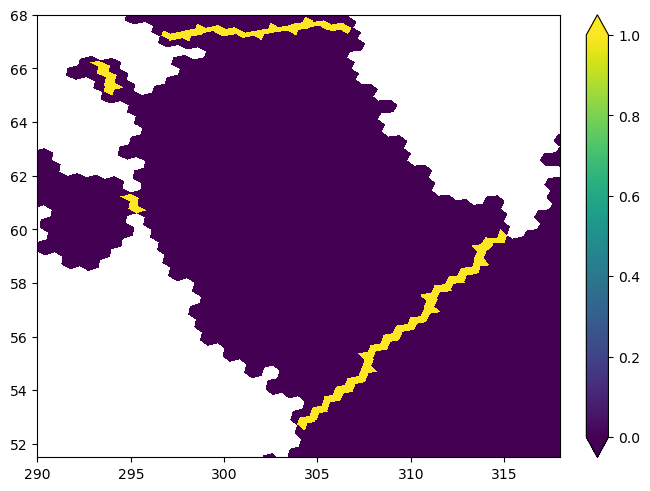

In [80]:
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
# LS
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(test_edge_transect),other=0)

# GofM
# base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(next_vertices),other=1)

edgemask = base_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)

# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  edgemask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')

# LS
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)

# # GofM
# ax.set_xlim(250, 318)
# ax.set_ylim(15, 35)

In [28]:
# LS_lats= np.array([54, 60, 66, 64, 58])   
# LS_lons= np.array([302, 315, 310, 295, 296])

# LS_lats = np.append(LS_lats, LS_lats[0])
# LS_lons = np.append(LS_lons, LS_lons[0])

# test_verts, test_edges = calculate_transects_multiple_pts(LS_lons, LS_lats, mesh, mask)

In [29]:
mesh

<xarray.Dataset> Size: 1GB
Dimensions:                        (nCells: 236853, nEdges: 719506,
                                    nVertices: 482371, TWO: 2, maxEdges: 7,
                                    maxEdges2: 14, vertexDegree: 3,
                                    nVertLevels: 60, Time: 1,
                                    nVertLevelsP1: 61, nForcingGroupsMax: 4)
Coordinates:
    VertexID                       (nVertices) int32 2MB 1 2 3 ... 482370 482371
Dimensions without coordinates: nCells, nEdges, nVertices, TWO, maxEdges,
                                maxEdges2, vertexDegree, nVertLevels, Time,
                                nVertLevelsP1, nForcingGroupsMax
Data variables: (12/73)
    latCell                        (nCells) float64 2MB 1.57 -0.4633 ... 0.1429
    lonCell                        (nCells) float64 2MB 5.919 0.6299 ... 2.347
    xCell                          (nCells) float64 2MB ...
    yCell                          (nCells) float64 2MB ...
    zCell                          (nCells) float64 2MB ...
    indexToCellID                  (nCells) int32 947kB ...
    ...                             ...
    accumulatedLandIceFrazilMass   (Time, nCells) float64 2MB ...
    frazilSurfacePressure          (Time, nCells) float64 2MB ...
    filteredSSHGradientZonal       (Time, nCells) float64 2MB ...
    filteredSSHGradientMeridional  (Time, nCells) float64 2MB ...
    forcingGroupNames              (Time, nForcingGroupsMax) |S64 256B ...
    forcingGroupRestartTimes       (Time, nForcingGroupsMax) |S64 256B ...
Attributes: (12/1166)
    on_a_sphere:                                                   YES
    sphere_radius:                                                 6371229.0
    model_name:                                                    mpas
    core_name:                                                     ocean
    history:                                                       Thu Feb 11...
    source:                                                        MPAS
    ...                                                            ...
    config_rx1_min_layer_thickness:                                1.0
    file_id:                                                       99ljfzad8z
    NCO:                                                           netCDF Ope...
    is_periodic:                                                   YES
    x_period:                                                      360
    y_period:                                                      0.0

### Here would be a good place to put a function to calculate the transect for this "mesh"

beginning masked.where


(51.5, 68.0)

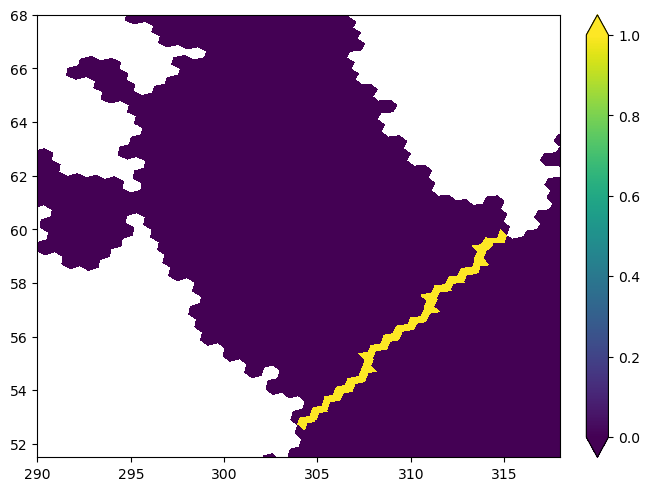

In [30]:
# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# ds_t0 = dso['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=30,Time=0)

# ds_t0 = dso['timeMonthly_avg_latentHeatFlux'].isel(Time=0)

ds_t0 = dso['timeMonthly_avg_normalVelocitySquared'].isel(Time=0,nVertLevels=0)

# remove the nans
if ds_t0.min() < -9**33:
    ds_nonans = ds_t0.where(ds_t0 > -9**33)
    print('fake nans detected')
else:
    ds_nonans = ds_t0

# apply the mask
# ds_masked = ds_nonans.where(cellmask,drop=False)
print('beginning masked.where')
ds_masked = ds_nonans.where(edgemask,drop=False)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  edgemask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
# ax.set_xlim(0, 360)


finished selecting base_mask values
converted test_mask to bool
beginning masked.where


(51.5, 68.0)

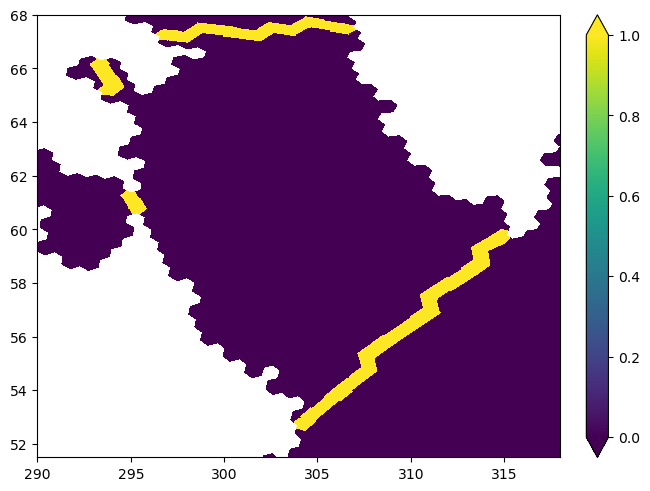

In [31]:
# xr_transect_vertices
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
#base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(n_border_cells+1), other = 1)
base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(mask_transect_cells), other = 0)
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(test_edge_transect),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(xr_transect_vertices),other=0)
print('finished selecting base_mask values')

test_mask = base_mask

# convert the 1s and 0s new mask to boolean T/F
cellmask = test_mask.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = test_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = test_mask.regionVertexMasks.isel(nRegions=0).astype(bool)
print('converted test_mask to bool')


# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# ds_t0 = dso['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=30,Time=0)

# ds_t0 = dso['timeMonthly_avg_latentHeatFlux'].isel(Time=0)

ds_t0 = dso['timeMonthly_avg_normalVelocitySquared'].isel(Time=0,nVertLevels=0)

# remove the nans
if ds_t0.min() < -9**33:
    ds_nonans = ds_t0.where(ds_t0 > -9**33)
    print('fake nans detected')
else:
    ds_nonans = ds_t0

# apply the mask
# ds_masked = ds_nonans.where(cellmask,drop=False)
print('beginning masked.where')
ds_masked = ds_nonans.where(edgemask,drop=False)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  vertexmask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
# ax.set_xlim(0, 360)


(51.5, 68.0)

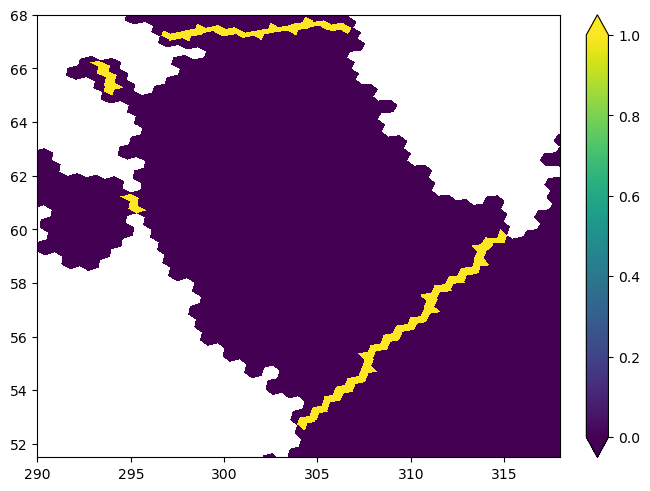

In [32]:
# edgemask
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  edgemask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
# ax.set_xlim(0, 360)


(51.5, 68.0)

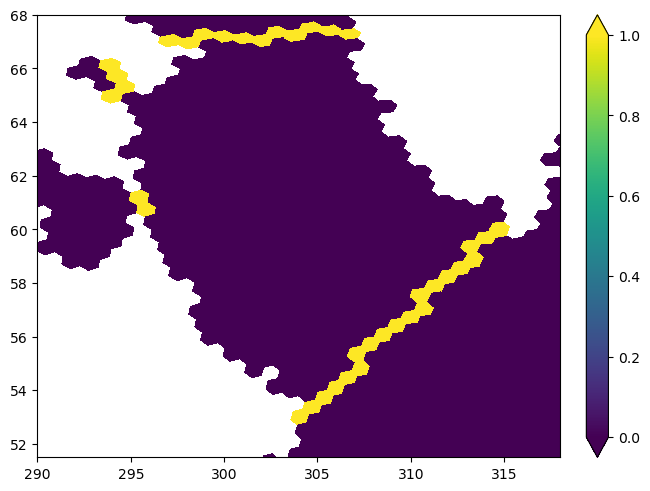

In [33]:
# cellmask
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
# ax.set_xlim(0, 360)


In [34]:
# get the cells that share an edge with the border cells
n_cellsOnBorderEdges = np.unique(mesh.cellsOnEdge.isel(nEdges = xr_border_edges))
xr_cellsOnBorderEdges = n_to_xr_idx(n_cellsOnBorderEdges)

# we only want the cells that share an edge with the border cells AND are inside the mask
mask_transect_cells = np.intersect1d(xr_cellsOnBorderEdges, xr_cells_inside)

finished selecting base_mask values
converted test_mask to bool
beginning masked.where


(51.5, 68.0)

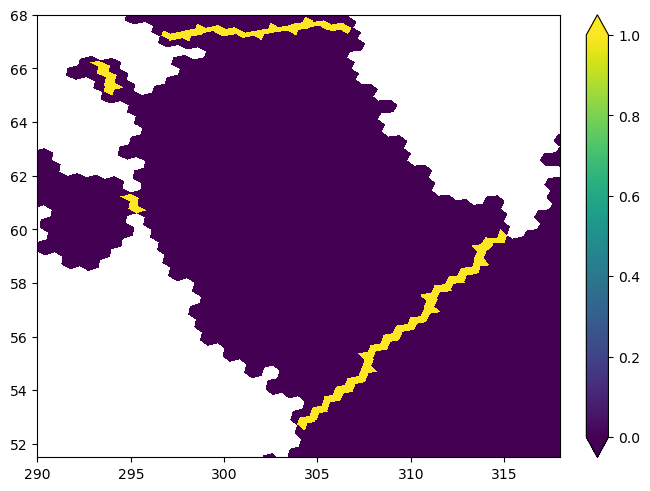

In [35]:
# xr_border_edges
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
#base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(n_border_cells+1), other = 1)
base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(mask_transect_cells), other = 0)
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(xr_border_edges),other=0)
# base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(xr_border_vertices),other=1)
print('finished selecting base_mask values')

test_mask = base_mask

# convert the 1s and 0s new mask to boolean T/F
cellmask = test_mask.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = test_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = test_mask.regionVertexMasks.isel(nRegions=0).astype(bool)
print('converted test_mask to bool')


# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# ds_t0 = dso['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=30,Time=0)

# ds_t0 = dso['timeMonthly_avg_latentHeatFlux'].isel(Time=0)

ds_t0 = dso['timeMonthly_avg_normalVelocitySquared'].isel(Time=0,nVertLevels=0)

# remove the nans
if ds_t0.min() < -9**33:
    ds_nonans = ds_t0.where(ds_t0 > -9**33)
    print('fake nans detected')
else:
    ds_nonans = ds_t0

# apply the mask
# ds_masked = ds_nonans.where(cellmask,drop=False)
print('beginning masked.where')
ds_masked = ds_nonans.where(edgemask,drop=False)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  edgemask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
# ax.set_xlim(0, 360)


attempt to plot the cells that are inside the mask by at the border 
xr_cellsOnBorderEdges
cells_inside

finished selecting base_mask values
converted test_mask to bool
beginning masked.where


(51.5, 68.0)

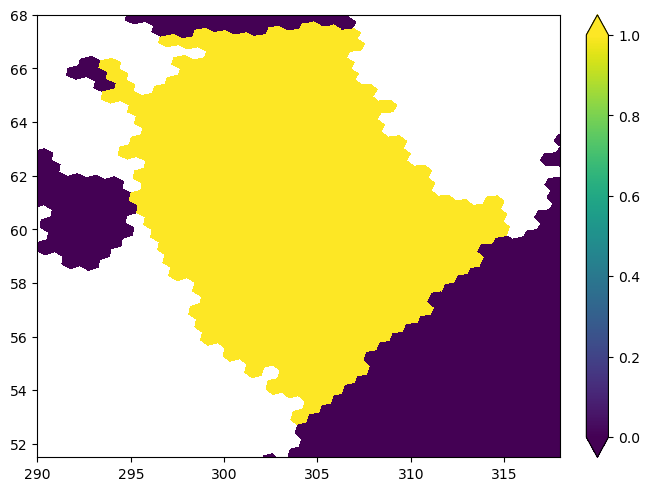

In [36]:
# xr_cells_inside
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
#base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(n_border_cells+1), other = 1)
base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(xr_cells_inside), other = 0)
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(xr_border_edges),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(xr_border_vertices),other=0)
print('finished selecting base_mask values')

test_mask = base_mask

# convert the 1s and 0s new mask to boolean T/F
cellmask = test_mask.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = test_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = test_mask.regionVertexMasks.isel(nRegions=0).astype(bool)
print('converted test_mask to bool')


# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# ds_t0 = dso['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=30,Time=0)

# ds_t0 = dso['timeMonthly_avg_latentHeatFlux'].isel(Time=0)

ds_t0 = dso['timeMonthly_avg_normalVelocitySquared'].isel(Time=0,nVertLevels=0)

# remove the nans
if ds_t0.min() < -9**33:
    ds_nonans = ds_t0.where(ds_t0 > -9**33)
    print('fake nans detected')
else:
    ds_nonans = ds_t0

# apply the mask
# ds_masked = ds_nonans.where(cellmask,drop=False)
print('beginning masked.where')
ds_masked = ds_nonans.where(edgemask,drop=False)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
# ax.set_xlim(0, 360)


finished selecting base_mask values
converted test_mask to bool
beginning masked.where


(51.5, 68.0)

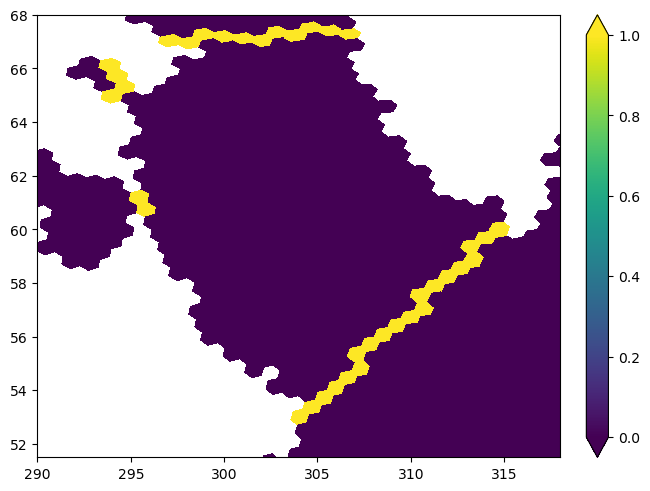

In [37]:
# mask_transect_cells
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')
#base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(n_border_cells+1), other = 1)
base_mask['regionCellMasks'] = base_mask.regionCellMasks.where(base_mask.nCells.isin(mask_transect_cells), other = 0)
base_mask['regionEdgeMasks'] = base_mask.regionEdgeMasks.where(base_mask.nEdges.isin(xr_border_edges),other=0)
base_mask['regionVertexMasks'] = base_mask.regionVertexMasks.where(base_mask.nVertices.isin(xr_border_vertices),other=0)
print('finished selecting base_mask values')

test_mask = base_mask

# convert the 1s and 0s new mask to boolean T/F
cellmask = test_mask.regionCellMasks.isel(nRegions=0).astype(bool)
edgemask = test_mask.regionEdgeMasks.isel(nRegions=0).astype(bool)
vertexmask = test_mask.regionVertexMasks.isel(nRegions=0).astype(bool)
print('converted test_mask to bool')


# scratch plot to check stuff
# set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)


# ds_t0 = dso['timeMonthly_avg_activeTracers_temperature'].isel(nVertLevels=30,Time=0)

# ds_t0 = dso['timeMonthly_avg_latentHeatFlux'].isel(Time=0)

ds_t0 = dso['timeMonthly_avg_normalVelocitySquared'].isel(Time=0,nVertLevels=0)

# remove the nans
if ds_t0.min() < -9**33:
    ds_nonans = ds_t0.where(ds_t0 > -9**33)
    print('fake nans detected')
else:
    ds_nonans = ds_t0

# apply the mask
# ds_masked = ds_nonans.where(cellmask,drop=False)
print('beginning masked.where')
ds_masked = ds_nonans.where(edgemask,drop=False)

# plot
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True)
c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='viridis',
                  antialiaseds=False)
fig.colorbar(c, extend='both')
ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
# ax.set_xlim(0, 360)


<div class="alert alert-block alert-info">
<b>Everything above this is somewhat correct except for the boolean / .where choices...:</b> Stop.
</div>

### check indices between n and xr for Cells
`isel` with `xr` coordinate.\
Returns datavariable in `n` coordinate.

In [38]:
# get the edges connected to a cell with the xr_ID of 0 (isel(nCells=0)). Then choose the first edge of that cell
# returns edges in the n coordinate
edge_nCell0_0 = mesh.edgesOnCell.isel(nCells=0).values[0] 
display(edge_nCell0_0)

# convert the edge in the n coordinate to the xr coordinate (xr = n -1) 
xr_edge_nCell0_0 = edge_nCell0_0 -1
display(xr_edge_nCell0_0)

# check our work 
# get the cells connected to an edge identified with xr_ID and n
mesh.cellsOnEdge.isel(nEdges=xr_edge_nCell0_0).values
# indices returned in the ncell indices

np.int32(288637)

np.int32(288636)

array([     1, 234052], dtype=int32)

### check indices between n and xr for Vertices

In [39]:
# get the vertices connected to a cell with the xr_ID of 0 (isel(nCells=0)). then choose the first vertex of that cell
# returns vertices in the n coordinate
nCell_idx = 0
vert_nCell0_0 = mesh.verticesOnCell.isel(nCells=nCell_idx).values[0]
display(vert_nCell0_0)

# convert the vertex in the n coordinate to the xr coordinate (xr = n-1)
xr_vert_nCell0_0 = n_to_xr_idx(vert_nCell0_0)
display(xr_vert_nCell0_0)

# check our work
# get the cells connected to the vertex identified with xr_ID and n
nCell_vert31235_0 = mesh.cellsOnVertex.isel(nVertices = xr_vert_nCell0_0).values

# indices returned in the ncell indices. Convert ncell index to xr index
nCell_from_vertex = n_to_xr_idx(nCell_vert31235_0)
display(nCell_from_vertex)


np.int32(31236)

np.int32(31235)

array([234050,      0, 234051], dtype=int32)